In [26]:
#!pip install pytorch_lightning
!pip install pytorch_lightning==0.9.0

In [27]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.nn import functional as F

import os
import random
from PIL import Image
from skimage import io
from skimage.color import gray2rgb

from torch.utils.data import Dataset

import warnings

from torch.optim import Adam
from torch.utils.data import DataLoader

from torchvision import transforms
from torchvision.models import resnet101
import pytorch_lightning as pl

from pytorch_lightning import Trainer
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

AEI-Net consists of 3 stages

1 stage) Creating Multi-Level Attributes Encoder. It's a U-Net-like encoder-decoder.

In original, it has 7 hidden blocks after input layer in encoder part. I'm using 4 of them. Conv nets also using different strides to downsize picture in 4 blocks. Convolution output sizes are following:


*   32x64x64
*   128x16x16
*   512x4x4
*   512x2x2

Decoder had 6 blocks. I'm using 3. Transposed convolution output sizes are:


*   512x4x4
*   128x16x16
* 32x64x64









In [29]:
class MultilevelAttributesEncoder(nn.Module):
    def __init__(self):
        super(MultilevelAttributesEncoder, self).__init__()
        self.Encoder_channel = [3, 32, 128, 512, 512]
        self.stride_sizes_encoder = [2, 4, 4, 2]
        self.Encoder = nn.ModuleDict({f'layer_{i}' : nn.Sequential(
                nn.Conv2d(self.Encoder_channel[i], 
                          self.Encoder_channel[i+1],
                          kernel_size=4, 
                          stride=self.stride_sizes_encoder[i],
                          padding=1),
                nn.BatchNorm2d(self.Encoder_channel[i+1]),
                nn.LeakyReLU(0.1)
            )for i in range(4)})

        self.Decoder_inchannel = [512, 1024, 256]
        self.Decoder_outchannel = [512, 128, 32]
        self.stride_sizes_decoder = [2, 4, 4]
        self.padding_sizes_decoder = [1, 0, 0]
        self.Decoder = nn.ModuleDict({f'layer_{i}' : nn.Sequential(
                nn.ConvTranspose2d(self.Decoder_inchannel[i], 
                                   self.Decoder_outchannel[i], 
                                   kernel_size=4, 
                                   stride=self.stride_sizes_decoder[i],
                                   padding=self.padding_sizes_decoder[i]),
                nn.BatchNorm2d(self.Decoder_outchannel[i]),
                nn.LeakyReLU(0.1)
            )for i in range(3)})

        self.Upsample = nn.UpsamplingBilinear2d(scale_factor=2)

    def forward(self, x):
        arr_x = []
        #encode_x = []
        for i in range(4):
            x = self.Encoder[f'layer_{i}'](x)
            arr_x.append(x)
        
        arr_y = []
        arr_y.append(arr_x[3])
        y = arr_x[3]
        for i in range(3):
            y = self.Decoder[f'layer_{i}'](y)
            y = torch.cat((y, arr_x[2-i]), 1)
            arr_y.append(y)

        arr_y.append(self.Upsample(y))

        return arr_y


In [30]:
model = MultilevelAttributesEncoder()
print(model)

MultilevelAttributesEncoder(
  (Encoder): ModuleDict(
    (layer_0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (layer_1): Sequential(
      (0): Conv2d(32, 128, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (layer_2): Sequential(
      (0): Conv2d(128, 512, kernel_size=(4, 4), stride=(4, 4), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (layer_3): Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyRe

2)Adaptive Attentional Denormalization Generator (including Identity Encoder).

Originally, it consists of 8 Adaptive Attentional Denormalization blocks, followed by bilinear upsampling. I'm using 5 of them, followed by bilinear upsampling with scales respectively to stride sizes in 1st part. The output shapes of Adaptive Attentional Denormalization blocks after upsampling are:


*   512x4x4
*   256x16x16
* 128x64x64
* 64x128x128
* 3x128x128



In [31]:
class ADD(nn.Module):
    def __init__(self, h_inchannel, z_inchannel, z_id_size=256):
        super(ADD, self).__init__()

        self.BNorm = nn.BatchNorm2d(h_inchannel)
        self.conv_f = nn.Conv2d(h_inchannel, h_inchannel, kernel_size=3, stride=1, padding=1)

        self.sigmoid = nn.Sigmoid()

        self.fc_1 = nn.Linear(z_id_size, h_inchannel)
        self.fc_2 = nn.Linear(z_id_size, h_inchannel)

        self.conv1 = nn.Conv2d(z_inchannel, h_inchannel, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(z_inchannel, h_inchannel, kernel_size=3, stride=1, padding=1)

    def forward(self, h_in, z_att, z_id):
        h_bar = self.BNorm(h_in)
        M = self.sigmoid(self.conv_f(h_bar))

        r_id = self.fc_1(z_id).unsqueeze(-1).unsqueeze(-1).expand_as(h_in)
        beta_id = self.fc_2(z_id).unsqueeze(-1).unsqueeze(-1).expand_as(h_in)

        I = r_id*h_bar + beta_id

        r_att = self.conv1(z_att)
        beta_att = self.conv2(z_att)
        A = r_att * h_bar + beta_att

        h_out = (1-M)*A + M*I

        return h_out

In [32]:
class ADDResBlock(nn.Module):
    def __init__(self, h_inchannel, z_inchannel, h_outchannel):
        super(ADDResBlock, self).__init__()

        self.h_inchannel = h_inchannel
        self.z_inchannel = z_inchannel
        self.h_outchannel = h_outchannel

        self.add1 = ADD(h_inchannel, z_inchannel)
        self.add2 = ADD(h_inchannel, z_inchannel)

        self.conv1 = nn.Conv2d(h_inchannel, h_inchannel, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(h_inchannel, h_outchannel, kernel_size=3, stride=1, padding=1)

        if self.h_inchannel != self.h_outchannel:
            self.add3 = ADD(h_inchannel, z_inchannel)
            self.conv3 = nn.Conv2d(h_inchannel, h_outchannel, kernel_size=3, stride=1, padding=1)

        self.activation = nn.ReLU()

    def forward(self, h_in, z_att, z_id):
        x1 = self.activation(self.add1(h_in, z_att, z_id))
        x1 = self.conv1(x1)
        x1 = self.activation(self.add2(x1, z_att, z_id))
        x1 = self.conv2(x1)

        x2 = h_in
        if self.h_inchannel != self.h_outchannel:
            x2 = self.activation(self.add3(h_in, z_att, z_id))
            x2 = self.conv3(x2)

        return x1 + x2


class ADDGenerator(nn.Module):
    def __init__(self, z_id_size):
        super(ADDGenerator, self).__init__()

        self.convt = nn.ConvTranspose2d(z_id_size, 512, kernel_size=2, stride=1, padding=0)
        
        self.h_inchannel = [512, 512, 256, 128, 64]
        self.z_inchannel = [512, 1024, 256, 64, 64]
        self.h_outchannel = [512, 256, 128, 64, 3]
        self.upsample_scale = [2, 4, 4, 2]
        
        self.model = nn.ModuleDict(
            {f"layer_{i}" : ADDResBlock(self.h_inchannel[i], self.z_inchannel[i], self.h_outchannel[i])
        for i in range(5)})


    def forward(self, z_id, z_att):
        x = self.convt(z_id.unsqueeze(-1).unsqueeze(-1))

        for i in range(4):
            x = self.model[f"layer_{i}"](x, z_att[i], z_id)
            x = nn.UpsamplingBilinear2d(scale_factor=self.upsample_scale[i])(x)
        x = self.model["layer_4"](x, z_att[4], z_id)

        return nn.Sigmoid()(x)

In [33]:
model = ADDGenerator(256)
print(model)

ADDGenerator(
  (convt): ConvTranspose2d(256, 512, kernel_size=(2, 2), stride=(1, 1))
  (model): ModuleDict(
    (layer_0): ADDResBlock(
      (add1): ADD(
        (BNorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_f): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (sigmoid): Sigmoid()
        (fc_1): Linear(in_features=256, out_features=512, bias=True)
        (fc_2): Linear(in_features=256, out_features=512, bias=True)
        (conv1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (conv2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (add2): ADD(
        (BNorm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv_f): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (sigmoid): Sigmoid()
        (fc_1): Linear(in_features=256, out_features=512, bias=True)
        (fc_2)

In [34]:
class MultiscaleDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d, num_D=3):
        super(MultiscaleDiscriminator, self).__init__()
        self.num_D = num_D
        self.n_layers = n_layers

        for i in range(num_D):
            netD = NLayerDiscriminator(input_nc, ndf, n_layers, norm_layer)
            setattr(self, 'layer' + str(i), netD.model)

        self.downsample = nn.AvgPool2d(3, stride=2, padding=[1, 1], count_include_pad=False)

    def singleD_forward(self, model, input):
        return [model(input)]

    def forward(self, input):
        num_D = self.num_D
        result = []
        input_downsampled = input
        for i in range(num_D):
            model = getattr(self, 'layer' + str(num_D - 1 - i))
            result.append(self.singleD_forward(model, input_downsampled))
            if i != (num_D - 1):
                input_downsampled = self.downsample(input_downsampled)
        return result



Using Multi-Scale Discriminator from pix2pixHD, based on PatchGAN


In [37]:
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        super(NLayerDiscriminator, self).__init__()
        self.n_layers = n_layers

        kernel_window = 4
        padw = int(np.ceil((kernel_window - 1.0) / 2))
        sequence = [[nn.Conv2d(input_nc, ndf, kernel_size=kernel_window, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]]

        nf = ndf
        for n in range(1, n_layers):
            nf_prev = nf
            nf = min(nf * 2, 512)
            sequence += [[
                nn.Conv2d(nf_prev, nf, kernel_size=kernel_window, stride=2, padding=padw),
                norm_layer(nf), nn.LeakyReLU(0.2, True)
            ]]

        nf_prev = nf
        nf = min(nf * 2, 512)
        sequence += [[
            nn.Conv2d(nf_prev, nf, kernel_size=kernel_window, stride=1, padding=padw),
            norm_layer(nf),
            nn.LeakyReLU(0.2, True)
        ]]

        sequence += [[nn.Conv2d(nf, 1, kernel_size=kernel_window, stride=1, padding=padw)]]

        sequence_stream = []
        for n in range(len(sequence)):
            sequence_stream += sequence[n]
        self.model = nn.Sequential(*sequence_stream)

    def forward(self, input):
        return self.model(input)

In [38]:
model = NLayerDiscriminator(3)
print(model)

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(2, 2))
  )
)


For discriminator hinge loss is implemented https://arxiv.org/pdf/1903.07291.pdf



In [39]:
class GANLoss(nn.Module):
    def __init__(self, target_real_label=1.0, target_fake_label=0.0, opt=None):
        super(GANLoss, self).__init__()
        self.real_label = target_real_label
        self.fake_label = target_fake_label
        self.real_label_tensor = None
        self.fake_label_tensor = None
        self.zero_tensor = None
        self.Tensor = torch.FloatTensor
        self.opt = opt

    def get_target_tensor(self, input, target_is_real):
        if target_is_real:
            return torch.ones_like(input).detach()
        else:
            return torch.zeros_like(input).detach()

    def get_zero_tensor(self, input):
        return torch.zeros_like(input).detach()

    def loss(self, input, target_is_real, for_discriminator=True):
        if for_discriminator:
            if target_is_real:
                minval = torch.min(input - 1, self.get_zero_tensor(input))
                loss = -torch.mean(minval)
            else:
                minval = torch.min(-input - 1, self.get_zero_tensor(input))
                loss = -torch.mean(minval)
        else:
            loss = -torch.mean(input)

        return loss
        
        
    def __call__(self, input, target_is_real, for_discriminator=True):
        if isinstance(input, list):
            loss = 0
            for pred_i in input:
                if isinstance(pred_i, list):
                    pred_i = pred_i[-1]
                loss_tensor = self.loss(pred_i, target_is_real, for_discriminator)
                bs = 1 if len(loss_tensor.size()) == 0 else loss_tensor.size(0)
                new_loss = torch.mean(loss_tensor.view(bs, -1), dim=1)
                loss += new_loss
            return loss / len(input)
        else:
            return self.loss(input, target_is_real, for_discriminator)


In [16]:
class AEI_Loss(nn.Module):
    def __init__(self):
        super(AEI_Loss, self).__init__()

        self.att_weight = 10
        self.id_weight = 5
        self.rec_weight = 10

        self.l1 = nn.L1Loss()
        self.l2 = nn.MSELoss()

    def att_loss(self, z_att_X, z_att_Y):
        loss = 0
        for i in range(5):
            loss += self.l2(z_att_X[i], z_att_Y[i])
        return 0.5*loss

    def id_loss(self, z_id_X, z_id_Y):
        inner_product = (torch.bmm(z_id_X.unsqueeze(1), z_id_Y.unsqueeze(2)).squeeze())
        return self.l1(torch.ones_like(inner_product), inner_product)

    def rec_loss(self, X, Y, same):
        same = same.unsqueeze(-1).unsqueeze(-1)
        same = same.expand(X.shape)
        X = torch.mul(X, same)
        Y = torch.mul(Y, same)
        return 0.5*self.l2(X, Y)

    def forward(self, X, Y, z_att_X, z_att_Y, z_id_X, z_id_Y, same):

        att_loss = self.att_loss(z_att_X, z_att_Y)
        id_loss = self.id_loss(z_id_X, z_id_Y)
        rec_loss = self.rec_loss(X, Y, same)

        return self.att_weight*att_loss + self.id_weight*id_loss + self.rec_weight*rec_loss, att_loss, id_loss, rec_loss


In [17]:
class AEINet(pl.LightningModule):
    def __init__(self):
        super(AEINet, self).__init__()
  
        self.G = ADDGenerator(256)
        self.E = MultilevelAttributesEncoder()
        self.D = MultiscaleDiscriminator(3)

        self.Z = resnet101(num_classes=256)
        self.Z.load_state_dict(torch.load('/content/drive/MyDrive/Arcface.pth', map_location='cpu'))

        self.Loss_GAN = GANLoss()
        self.Loss_E_G = AEI_Loss()


    def forward(self, target_img, source_img):
        z_id = self.Z(F.interpolate(source_img, size=112, mode='bilinear'))
        z_id = F.normalize(z_id)
        z_id = z_id.detach()

        feature_map = self.E(target_img)

        output = self.G(z_id, feature_map)

        output_z_id = self.Z(F.interpolate(output, size=112, mode='bilinear'))
        output_z_id = F.normalize(output_z_id)
        output_feature_map = self.E(output)
        return output, z_id, output_z_id, feature_map, output_feature_map


    def training_step(self, batch, batch_idx, optimizer_idx):
        target_img, source_img, same = batch

        if optimizer_idx == 0:
            output, z_id, output_z_id, feature_map, output_feature_map = self(target_img, source_img)

            self.generated_img = output

            output_multi_scale_val = self.D(output)
            loss_GAN = self.Loss_GAN(output_multi_scale_val, True, for_discriminator=False)
            loss_E_G, loss_att, loss_id, loss_rec = self.Loss_E_G(target_img, output, feature_map, output_feature_map, z_id,
                                                             output_z_id, same)

            loss_G = loss_E_G + loss_GAN

            sample_img = torch.rand((1, 3, 128, 128))
  
            self.logger.experiment.add_scalar("Loss G", loss_G.item(), self.global_step)
            self.logger.experiment.add_scalar("Attribute Loss", loss_att.item(), self.global_step)
            self.logger.experiment.add_scalar("ID Loss", loss_id.item(), self.global_step)
            self.logger.experiment.add_scalar("Reconstruction Loss", loss_rec.item(), self.global_step)

            self.logger.experiment.add_scalar("GAN Loss", loss_GAN.item(), self.global_step)

            return loss_G

        else:
            multi_scale_val = self.D(target_img)
            output_multi_scale_val = self.D(self.generated_img.detach())

            loss_D_fake = self.Loss_GAN(multi_scale_val, True)
            loss_D_real = self.Loss_GAN(output_multi_scale_val, False)

            loss_D = loss_D_fake + loss_D_real

            self.logger.experiment.add_scalar("Loss D", loss_D.item(), self.global_step)
            return loss_D

    def validation_step(self, batch, batch_idx):
        target_img, source_img, same = batch

        output, z_id, output_z_id, feature_map, output_feature_map = self(target_img, source_img)

        self.generated_img = output

        output_multi_scale_val = self.D(output)
        loss_GAN = self.Loss_GAN(output_multi_scale_val, True, for_discriminator=False)
        loss_E_G, loss_att, loss_id, loss_rec = self.Loss_E_G(target_img, output, feature_map, output_feature_map,
                                                              z_id, output_z_id, same)
        loss_G = loss_E_G + loss_GAN
        return {"loss": loss_G, 'target': target_img[0].cpu(), 'source': source_img[0].cpu(),  "output": output[0].cpu(), }

    def validation_end(self, outputs):
        loss = torch.stack([x["loss"] for x in outputs]).mean()
        validation_image = []
        for x in outputs:
            validation_image = validation_image + [x['target'], x['source'], x["output"]]
        validation_image = torchvision.utils.make_grid(validation_image, nrow=3)

        self.logger.experiment.add_scalar("Validation Loss", loss.item(), self.global_step)
        self.logger.experiment.add_image("Validation Image", validation_image, self.global_step)

        return {"loss": loss, "image": validation_image, }


    def configure_optimizers(self):
        lr_g = 4e-4
        lr_d = 4e-4
        b1 = 0
        b2 = 0.999

        opt_g = torch.optim.Adam(list(self.G.parameters()) + list(self.E.parameters()), lr=lr_g, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.D.parameters(), lr=lr_d, betas=(b1, b2))
        return [opt_g, opt_d], []

    def train_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.CenterCrop((128, 128)),
            transforms.ToTensor(),
            ])
        dataset = AEI_Dataset('/content/drive/MyDrive/data128x128', transform=transform)
        return DataLoader(dataset, batch_size=32, num_workers=4, shuffle=True, drop_last=True)

    def val_dataloader(self):
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.CenterCrop((128, 128)),
            transforms.ToTensor(),
        ])
        dataset = AEI_Val_Dataset('/content/drive/MyDrive/valset_dir', transform=transform)
        return DataLoader(dataset, batch_size=1, shuffle=False)


In [18]:
class AEI_Dataset(Dataset):
    def __init__(self, root, transform=None):
        super(AEI_Dataset, self).__init__()
        self.root = root
        self.files = [
            os.path.join(path, filename)
            for path, dirs, files in os.walk(root)
            for filename in files
            if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg")
        ]
        self.transform = transform


    def __getitem__(self, index):
        l = len(self.files)
        s_idx = index%l
        if index >= 4*l:
            f_idx = s_idx

        else:
            f_idx = random.randrange(l)


        if f_idx == s_idx:
            same = torch.ones(1)
        else:
            same = torch.zeros(1)

        f_img = Image.open(self.files[f_idx])
        s_img = Image.open(self.files[s_idx])

        f_img = f_img.convert('RGB')
        s_img = s_img.convert('RGB')

        if self.transform is not None:
            f_img = self.transform(f_img)
            s_img = self.transform(s_img)

        return f_img, s_img, same

    def __len__(self):
        return len(self.files)


class AEI_Val_Dataset(Dataset):
    def __init__(self, root, transform=None):
        super(AEI_Val_Dataset, self).__init__()
        self.root = root
        self.files = [
            os.path.join(path, filename)
            for path, dirs, files in os.walk(root)
            for filename in files
            if filename.endswith(".png") or filename.endswith(".jpg") or filename.endswith(".jpeg")
        ]
        self.transfrom = transform

    def __getitem__(self, index):
        l = len(self.files)

        f_idx = index // l
        s_idx = index % l

        if f_idx == s_idx:
            same = torch.ones(1)
        else:
            same = torch.zeros(1)

        f_img = Image.open(self.files[f_idx])
        s_img = Image.open(self.files[s_idx])

        f_img = f_img.convert('RGB')
        s_img = s_img.convert('RGB')

        if self.transfrom is not None:
            f_img = self.transfrom(f_img)
            s_img = self.transfrom(s_img)

        return f_img, s_img, same

    def __len__(self):
        return len(self.files) * len(self.files)

In [19]:
def main(name, checkpoint_path):
    model = AEINet()
    save_path = os.path.join('/content/drive/MyDrive/chkp', name)
    os.makedirs(save_path, exist_ok=True)

    checkpoint_callback = ModelCheckpoint(
        filepath=os.path.join('/content/drive/MyDrive/chkp', name),
        monitor='val_loss',
        verbose=True,
        save_top_k=-1
    )

    trainer = Trainer(
        logger=pl_loggers.TensorBoardLogger('/content/drive/MyDrive/log_dir'),
        early_stop_callback=None,
        checkpoint_callback=checkpoint_callback,
        weights_save_path=save_path,
        gpus=-1,
        num_sanity_val_steps=1,
        resume_from_checkpoint=checkpoint_path,
        gradient_clip_val=0,
        progress_bar_refresh_rate=1,
        max_epochs=10000,
    )
    trainer.fit(model)


In [20]:
#main('start128_8', '/content/drive/MyDrive/epoch_dir/epoch=9.ckpt')

In [27]:
def start_all_epochs(img_dir, num_epochs, target_img_path, source_img_path):
  device = torch.device('cuda')
  out_images = []
  time_inference = []
  for i in range(5,6):
    file_name = f'epoch={i}.ckpt'
    model = AEINet.load_from_checkpoint(os.path.join(img_dir, file_name))
    model.eval()
    model.freeze()
    model.to(device)
    target_img = transforms.ToTensor()(Image.open(target_img_path)).unsqueeze(0).to(device)
    source_img = transforms.ToTensor()(Image.open(source_img_path)).unsqueeze(0).to(device)
    
    start = time.time()
    with torch.no_grad():
      output, _, _, _, _ = model.forward(target_img, source_img)
    end = time.time()
    output = transforms.ToPILImage()(output.cpu().squeeze().clamp(0, 1))
    out_images.append(output)
    time_inference.append(end-start)
  return out_images, time_inference

In [28]:
from matplotlib import pyplot
import time

In [29]:
target_in_source_in, time_inference = start_all_epochs('/content/drive/MyDrive/epoch_dir', 10, '/content/drive/MyDrive/valset_dir/00002.jpg', '/content/drive/MyDrive/valset_dir/00005.jpg')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


0.0370335578918457


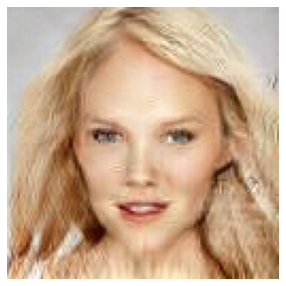

In [30]:
#pyplot.figure(figsize=(15, 15))
for i in range(1):  
  pyplot.figure(figsize=(5, 5))
  pyplot.imshow(target_in_source_in[i])
  print(time_inference[i])
  pyplot.axis('off')
  #pyplot.figsize((60, 60))
#pyplot.show()


In [ ]:
validation_image = []
for x in outputs:
    validation_image = validation_image + [x['target'], x['source'], x["output"]]
validation_image = torchvision.utils.make_grid(validation_image, nrow=3)